In [1]:
DATA_PATH = 'data/xlsx/FRS_simulations_with_sex_and_lung_cancer.xlsx'

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split, DataLoader
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate
from tqdm import tqdm
from sklearn.metrics import RocCurveDisplay, roc_auc_score

from src.datasets import LabeledDataset
from src.models import *

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
df = pd.read_excel(DATA_PATH)

In [6]:
inputs = df[df.columns[:-2]].astype(complex).values
inputs = np.stack((
    inputs.real,
    inputs.imag,
    np.abs(inputs),
    np.abs(inputs)
), axis=-1)

In [7]:
ds = TensorDataset(torch.tensor(inputs), torch.tensor(df['Label'].values), torch.tensor(df['sex_numeric'].values))

In [8]:
ds = LabeledDataset(ds, active_label=1)

generator = torch.Generator().manual_seed(42)
splits = random_split(ds, [.8, .1, .1], generator)
ds = {
    'train': splits[0],
    'dev': splits[1],
    'test': splits[2]
}

In [9]:
model = MLPModel([2048, 1024, 512, 256], nn.PReLU).cuda()

In [10]:
training_args = TrainingArguments(
    output_dir='models',
    per_device_train_batch_size=1024,
    per_device_eval_batch_size=1024,
    learning_rate=1e-3,
    warmup_ratio=.1,
    num_train_epochs=100,
    weight_decay=.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=12,
    full_determinism=True
)

In [11]:
metrics = evaluate.combine(['accuracy', 'precision', 'recall', 'f1'])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return metrics.compute(logits > 0, labels.astype(bool))

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['dev'],
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(10)
    ]
)

In [13]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: protossluigi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.693151,0.496250,0.000000,0.000000,0.000000
2,No log,0.693025,0.552000,0.662300,0.225806,0.336788
3,No log,0.677912,0.565000,0.538678,0.950372,0.687612
4,No log,0.756273,0.542750,0.524333,0.994541,0.686654
5,No log,0.362497,0.836250,0.805206,0.890323,0.845628
6,No log,0.286422,0.884000,0.895461,0.871464,0.883300
7,No log,0.894057,0.606250,0.561384,0.998511,0.718700
8,No log,1.206770,0.624500,1.000000,0.254591,0.405854
9,No log,0.400661,0.797250,0.998344,0.598511,0.748371
10,No log,0.387403,0.819000,0.996157,0.643176,0.781665


/home/protossluigi/repos/molecular-fingerprinting/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3200, training_loss=0.20601430356502534, metrics={'train_runtime': 487.0561, 'train_samples_per_second': 6570.085, 'train_steps_per_second': 6.57, 'total_flos': 0.0, 'train_loss': 0.20601430356502534, 'epoch': 100.0})

In [14]:
trainer.evaluate(ds['test'], metric_key_prefix='test')

early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'test_loss': 0.061128027737140656,
 'test_accuracy': 0.97825,
 'test_precision': 0.9883307965499746,
 'test_recall': 0.9681908548707754,
 'test_f1': 0.9781571679638463,
 'test_runtime': 1.5067,
 'test_samples_per_second': 2654.883,
 'test_steps_per_second': 2.655,
 'epoch': 100.0}

In [16]:
dl = DataLoader(ds['test'], batch_size=1024, shuffle=False, pin_memory=True)

In [17]:
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(dl, desc='Evaluating'):
        y_true.append(batch['labels'])
        X_batch = batch['inputs'].to(device)
        logits = model(X_batch)['logits']
        y_pred.append(nn.functional.sigmoid(logits).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


In [18]:
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc}")

AUC: 0.9968351360648983


[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'Classification ROC')]

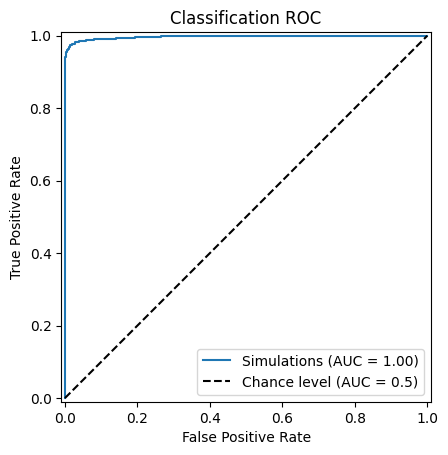

In [19]:
display = RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    name=f"Simulations",
    plot_chance_level=True,
    # despine=True,
)
display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Classification ROC",
)